# S4E1 - Bank Churn Predictions - Ensemble N Models

# Config

In [62]:
class Config():
    seed = 12
    folds = 5
    add_orig = True
    oofs = []
    preds = []
    models = []

config = Config()

# Imports

In [63]:
import random
import numpy as np 
import pandas as pd 
pd.set_option('display.max_columns', 50)

import matplotlib.pyplot as plt 
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm

# Load Files

In [64]:
root_dir = '/kaggle/input/playground-series-s4e1'
train = pd.read_csv(root_dir + '/train.csv') 
test = pd.read_csv(root_dir + '/test.csv') 
ss = pd.read_csv(root_dir + '/sample_submission.csv')

## Load original data

In [65]:
orig = pd.read_csv('/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv')
orig.drop('RowNumber',axis=1,inplace=True)
orig.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0


In [67]:
# a few values have nans in the orig data (like 3 rows), just drop them
orig.dropna(axis=0,inplace=True)
#orig.info()

In [69]:
train.drop('id',axis=1,inplace=True)

## Concatenate train + orig

In [70]:
if config.add_orig:
    train = pd.concat([train,orig],axis=0)

# Top Level EDA

In [71]:
# print all sets - assuming train,test, ss
print(f'Training Data Shape: {train.shape}') 
display(train.head()) 
print(f'Test Data Shape: {test.shape}') 
display(test.head()) 
print(f'Sample Submission Shape: {ss.shape}') 
display(ss.head())

Training Data Shape: (175032, 13)


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


Test Data Shape: (110023, 13)


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


Sample Submission Shape: (110023, 2)


,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


In [72]:
display(train.describe().style.background_gradient(cmap='Blues'))
display(test.describe().style.background_gradient(cmap='Blues'))

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,175032.000000,175032.000000,175032.000000,175032.000000,175032.000000,175032.000000,175032.000000,175032.000000,175032.000000,175032.000000
mean,15691944.087395,656.115945,38.171265,5.019933,56677.821792,1.553070,0.751188,0.498743,111862.236392,0.211156
std,71428.198859,81.149591,8.969537,2.811133,62982.219148,0.549211,0.432326,0.500000,50815.188500,0.408130
min,15565701.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,15632882.000000,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,73214.330000,0.000000
50%,15690169.000000,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,116969.730000,0.000000
75%,15756655.000000,710.000000,42.000000,7.000000,120727.970000,2.000000,1.000000,1.000000,154767.340000,0.000000
max,15815690.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000
mean,220045.000000,15692096.605101,656.530789,38.122205,4.996637,55333.611354,1.553321,0.753043,0.495233,112315.147765
std,31761.048671,71684.990992,80.315415,8.861550,2.806148,62788.519675,0.544714,0.431244,0.499980,50277.048244
min,165034.000000,15565701.000000,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,192539.500000,15632859.000000,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74440.325000
50%,220045.000000,15690175.000000,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117832.230000
75%,247550.500000,15756926.000000,710.000000,42.000000,7.000000,120145.605000,2.000000,1.000000,1.000000,154631.350000
max,275056.000000,15815690.000000,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


In [74]:
def num_of_unique_elements(df): 
  summary = pd.DataFrame(df.dtypes, columns=['dtypes']) 
  summary['missing#'] = df.isna().sum() 
  summary['missing%'] = (df.isna().sum())/len(df) 
  summary['uniques'] = df.nunique().values 
  summary['count'] = df.count().values 
  return summary

num_of_unique_elements(train).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count
CustomerId,int64,0,0.000000,23421,175032
Surname,object,0,0.000000,2932,175032
CreditScore,int64,0,0.000000,460,175032
Geography,object,0,0.000000,3,175032
Gender,object,0,0.000000,2,175032
Age,float64,0,0.000000,73,175032
Tenure,int64,0,0.000000,11,175032
Balance,float64,0,0.000000,30239,175032
NumOfProducts,int64,0,0.000000,4,175032
HasCrCard,float64,0,0.000000,2,175032


* 165K rows in train, 110K rows in test, 13 features + target
* No missing data
* Some categorical/binary columns
* Some columns have non-optimum data types
* Age should be int

In [75]:
# maybe later look at surname
#train.Surname.value_counts()
train.Geography.value_counts()

Geography
France     99227
Spain      38689
Germany    37116
Name: count, dtype: int64

## Convert Datatypes
* to something more reasonable
* Gender, HasCrCard, IsActiveMember, Exited to boolean


In [76]:
# convert colums to boolean 
bool_cols = [col for col in train.columns if train[col].nunique()==2]
train[bool_cols] = train[bool_cols].astype('bool')

y = train.Exited
bool_cols.remove('Exited')
test[bool_cols] = test[bool_cols].astype('bool')

In [77]:
# one hot encode non-ordinal columns (geography)
train = pd.concat([train, pd.get_dummies(train['Geography'])], axis=1)
test = pd.concat([test, pd.get_dummies(test['Geography'])], axis=1)
train

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,France,Germany,Spain
0,15674932,Okwudilichukwu,668,France,True,33.0,3,0.00,2,True,False,181449.97,False,True,False,False
1,15749177,Okwudiliolisa,627,France,True,33.0,1,0.00,2,True,True,49503.50,False,True,False,False
2,15694510,Hsueh,678,France,True,40.0,10,0.00,2,True,False,184866.69,False,True,False,False
3,15741417,Kao,581,France,True,34.0,2,148882.54,1,True,True,84560.88,False,True,False,False
4,15766172,Chiemenam,716,Spain,True,33.0,5,0.00,2,True,True,15068.83,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,15584532,Liu,709,France,True,36.0,7,0.00,1,False,True,42085.58,True,True,False,False
9998,15682355,Sabbatini,772,Germany,True,42.0,3,75075.31,2,True,False,92888.52,True,False,True,False
9999,15682355,Sabbatini,772,Germany,True,42.0,3,75075.31,2,True,False,92888.52,True,False,True,False
10000,15628319,Walker,792,France,True,28.0,4,130142.79,1,True,False,38190.78,False,True,False,False


In [78]:
train.drop('Geography', axis=1, inplace=True)
test.drop('Geography', axis=1, inplace=True)

In [79]:
not_used_cols = ['CustomerId','Surname']

train.drop(not_used_cols, axis=1, inplace=True)
test.drop(not_used_cols, axis=1, inplace=True)

# EDA of float cols

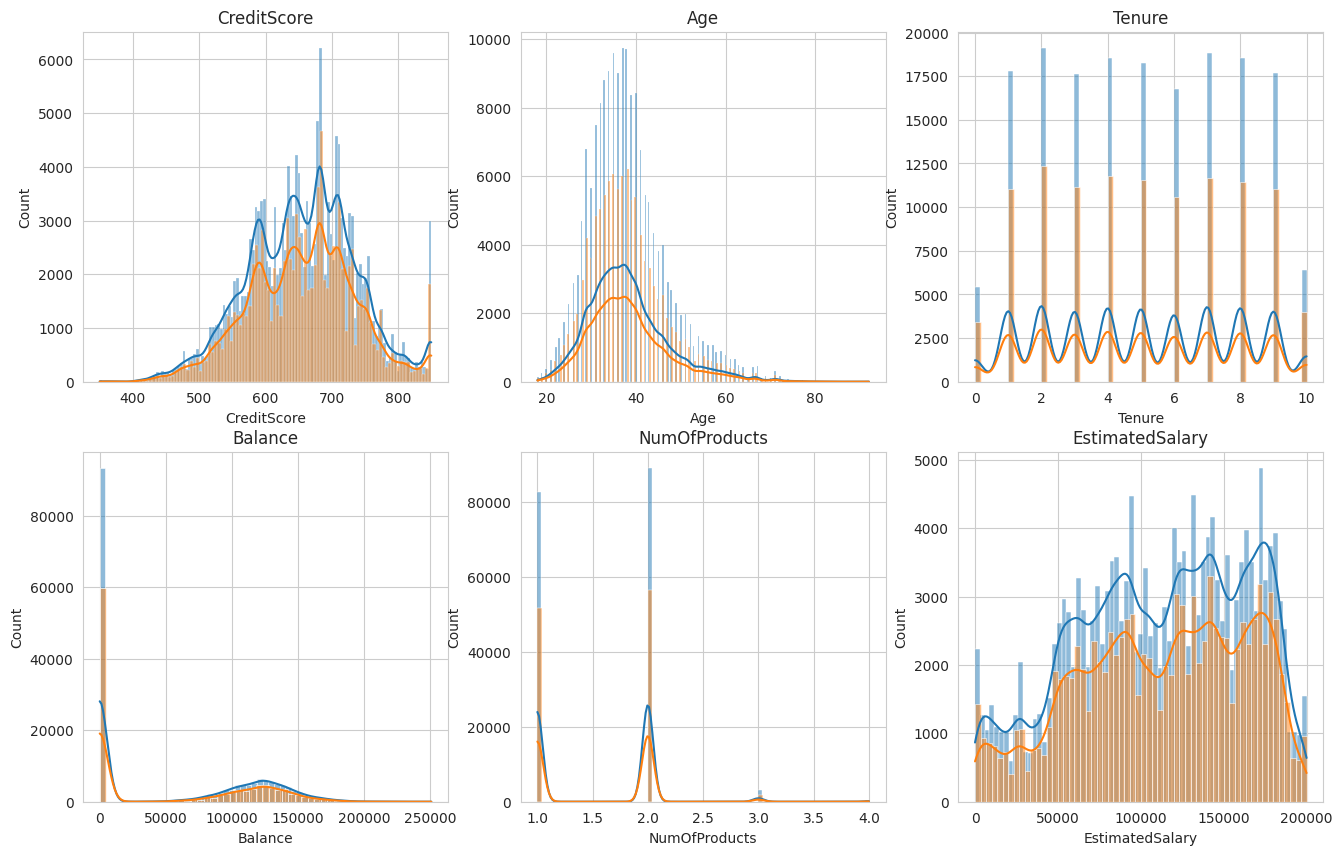

In [80]:
features = [col for col in train.columns if train[col].dtype=='float' or train[col].dtype=='int']
rows = int(np.ceil(len(features)/3)) 
plt.figure(figsize=(16,5*rows)) 
for i,col in enumerate(features): 
  plt.subplot(rows,3,i+1) 
  sns.histplot(train[col],kde=True) 
  sns.histplot(test[col], kde=True)
  plt.title(col)

Text(0.5, 1.0, 'Target Value Counts')

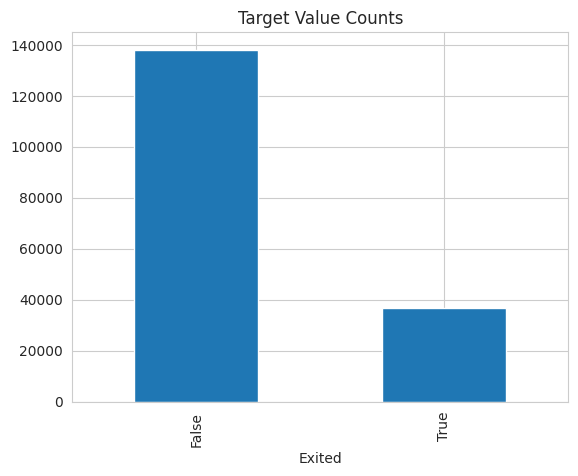

In [81]:
y.value_counts().plot(kind='bar')
plt.title('Target Value Counts')

* Some target class imbalance
    * Try oversampling

# Feature Engineering

# Correlations

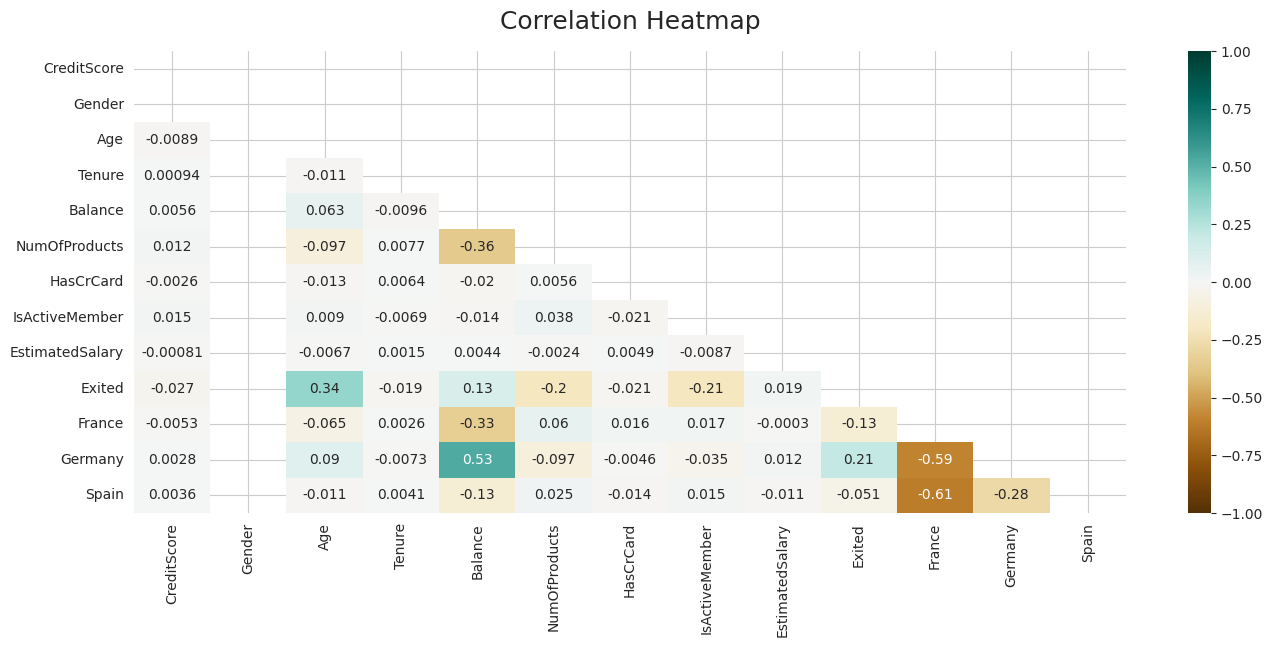

In [82]:
plt.figure(figsize=(16, 6)) 
mask = np.triu(np.ones_like(train.corr(),dtype=bool)) 
heatmap = sns.heatmap(train.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

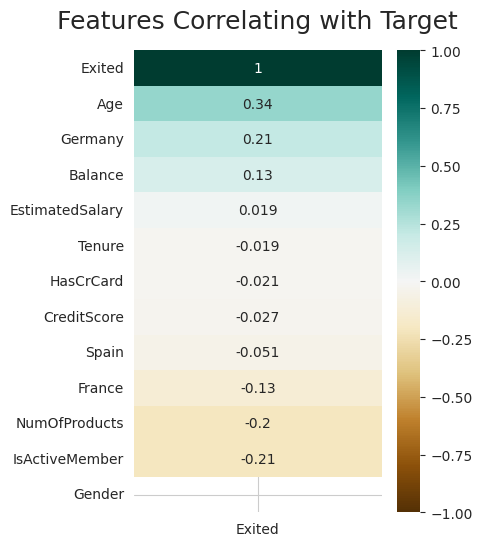

In [83]:
plt.figure(figsize=(4, 6)) # set size by num of features 
heatmap = sns.heatmap(train.corr()[['Exited']].sort_values(by='Exited', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG') 
heatmap.set_title('Features Correlating with Target', fontdict={'fontsize':18}, pad=16);

## Select Features

In [84]:
test.drop('id',axis=1,inplace=True)
features = [col for col in test.columns]
features

['CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'France',
 'Germany',
 'Spain']

# Models

In [85]:
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

## Train/test Split

In [86]:
X_train, X_valid, y_train, y_valid = train_test_split(train[features], y, train_size=0.8, test_size=0.2,
                                                      random_state=config.seed)
X_test = test[features]

### Cross Validation

In [87]:
def run_cv_and_predict(train, test, features, model, seed, verbose=True):
    
    # initialize arrays 
    fold_scores = []
    oof = np.zeros(train.shape[0])
    preds = np.zeros((test.shape[0],config.folds))

    # setup folding strategy
    skf = StratifiedKFold(n_splits=config.folds,random_state = config.seed,shuffle=True)

    # start cross validation
    cur_fold = 1
    for trn_idx, val_idx in skf.split(train[features], y):

        # split indicies into train and validation
        x_train = train[features].iloc[trn_idx]
        y_train = y.iloc[trn_idx]
        x_valid = train[features].iloc[val_idx]
        y_valid = y.iloc[val_idx]

        # fit model
        model.fit(x_train,y_train)

        # predict on validation set
        fold_preds = model.predict_proba(x_valid)[:,1]
        fold_preds = fold_preds.reshape(len(fold_preds)) # sbabwtdt
        oof[val_idx] = fold_preds

        # Compute scores
        fold_score = roc_auc_score(y_valid,fold_preds)  # CHOOSE METRIC HERE
        fold_scores.append(fold_score)
        if verbose:
          print(f'Score, fold {cur_fold}: {fold_score}')

        # predict on test set - store all fold preds (take mode later)
        test_preds = model.predict_proba(test[features])[:,1]
        test_preds = test_preds.reshape(len(test_preds))  # shouldn't have to do this.
        preds[:,cur_fold-1] = test_preds  
        cur_fold +=1
    
    # Print mean fold and oof score 
    oof_score = roc_auc_score(y,oof)
    # oof_score = np.sqrt(mean_squared_error(y,oof))
    print(f'ROC AUC score: {np.mean(fold_scores):.5f}, Stdev: {np.std(fold_scores):.5f}, OOF score: {oof_score:.5f}')
    # print(f'RMSE score: {np.mean(scores):.5f}, Stdev: {np.std(scores):.5f}, OOF score: {oof_score:.5f}')

    return (preds,fold_scores,oof_score,oof)

## Logistic Regression

In [88]:
# from sklearn.linear_model import LogisticRegression

# model_lr = LogisticRegression()

# preds_lr,scores_lr,oof_score_lr,oof_lr = run_cv_and_predict(train,test,features,model_lr,config.seed,verbose=True)

# config.oofs.append(oof_lr)
# config.preds.append(preds_lr)
# config.models.append('lr')
# default: 0.71144,                  lb = .70793
# with cross validation: .71380,     lb = .70791

## Decision Tree

In [89]:
from sklearn.tree import DecisionTreeClassifier

results = []
for msl in [10,]:
    for mss in [11]:
        for d in [8]:
            model_dt = DecisionTreeClassifier(min_samples_leaf=msl, min_samples_split=mss,max_depth=d)
            print(f'msl: {msl},mss: {mss},d:{d}')
            preds_dt,scores_dt,oof_score_dt,oof_dt = run_cv_and_predict(train,test,features,model_dt,config.seed,verbose=False)

            
config.oofs.append(oof_dt)
config.preds.append(preds_dt)
config.models.append('dt')
# default .69954
# max_depth = 3: .84321
# max_depth = 4: .86051
# max_depth = 5: .87173
# max_depth = 6: .88061, lb = .87575
# max_depth = 7: .88137, lb = .87771
# max_depth = 8: .88028, lb = .87785
# max_depth = 9: .87648


msl: 10,mss: 11,d:8
ROC AUC score: 0.87962, Stdev: 0.00203, OOF score: 0.87957


## Random Forest

In [90]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier()

preds_rf,scores_rf,oof_score_rf,oof_rf = run_cv_and_predict(train,test,features,model_rf,config.seed,verbose=True)

config.oofs.append(oof_rf)
config.preds.append(preds_rf)
config.models.append('rf')
# default: cv = .86870, lb = .87105
# default with orig: .86404

Score, fold 1: 0.8652093018334193
Score, fold 2: 0.86406125202126
Score, fold 3: 0.861270852363297
Score, fold 4: 0.8676462829060922
Score, fold 5: 0.8620138222949524
ROC AUC score: 0.86404, Stdev: 0.00229, OOF score: 0.86402


## Extra Trees

In [104]:
%%time
from sklearn.ensemble import ExtraTreesClassifier

results = []

for est in [500]:
    for md in [7]:
        for msl in [4]:
            model_etc = ExtraTreesClassifier(n_estimators=est,max_depth=md,min_samples_leaf=msl, random_state=config.seed)
            print(f'est: {est},md: {md}, msl: {msl}')
            preds_etc,scores_etc,oof_score_etc,oof_etc = run_cv_and_predict(train,test,features,model_etc,config.seed,verbose=False)
            results.append([est,md,msl,np.mean(scores_etc),oof_score_etc])
config.oofs.append(oof_etc)
config.preds.append(preds_etc)
config.models.append('etc')

#default etc = .86235, lb = .86639
# nest, max_depth, msl = 500,7,4, cv = .87727
# orig data: est: 500,md: 7, msl: 4,  ROC AUC score: 0.86332, Stdev: 0.00249, OOF score: 0.86326


est: 500,md: 4, msl: 7
ROC AUC score: 0.84234, Stdev: 0.00261, OOF score: 0.84233
CPU times: user 2min 22s, sys: 79.1 ms, total: 2min 23s
Wall time: 2min 23s


In [92]:
# model_etc.get_params()

# XGBoost

In [93]:
%%time
from xgboost import XGBClassifier

results = []

model_xgb = XGBClassifier(max_depth= 5, 
                          n_estimators= 500, 
                          learning_rate=0.04,
                          random_state= config.seed  
                          )

preds_xgb,scores_xgb,oof_score_xgb,oof_xgb = run_cv_and_predict(train,test,features,model_xgb,config.seed,verbose=True)

config.oofs.append(oof_xgb)
config.preds.append(preds_xgb)
config.models.append('xgb')

# default xgb = .88284, lb = .88212 (very close match)
# params1 (est,md,lr): 125,8,.03, cv = .88442, lb = .88022 
# 125,7,.05: .88507, lb = .88146
# 250,5,.04: .88544, lb = ,88190
# 500,5,.04: .88557, lb = .88265
# 1000,4,.03: .88570, lb = .88232
# 1000,4, .025: ROC AUC score: 0.88575, Stdev: 0.00232, OOF score: 0.88573, lb = .88221
# change to .02, .88569
# 2000, 3, .02: .88530
# 2000, 4, .02: .88569
# 1000, 5, .02: .88562
# 1000, 5, .01: .88545, ROC AUC score: 0.88545, Stdev: 0.00224, OOF score: 0.88542, lb = .88184
# 1000, 5, .03: .88538
# 1000, 5, .05: .88464, 
# 1000, 6 ,.05: .88307
# 1000, 4, .05: ROC AUC score: 0.88546, Stdev: 0.00254, OOF score: 0.88545
# 1000, 3, .05: ROC AUC score: 0.88574, Stdev: 0.00238, OOF score: 0.88573, lb = .88218
# 1000, 3, .04: ROC AUC score: 0.88566, Stdev: 0.00240, OOF score: 0.88564
# 1000, 3, .06: ROC AUC score: 0.88582, Stdev: 0.00240, OOF score: 0.88580, lb = .88224
# 1000, 3, .07, ROC AUC score: 0.88577, Stdev: 0.00234, OOF score: 0.88576
# 1500, 3, .07, ROC AUC score: 0.88553, Stdev: 0.00237, OOF score: 0.88552

# 500, 5, .04: ROC AUC score: 0.88557, Stdev: 0.00236, OOF score: 0.88555
# add orig: ROC AUC score: 0.88465, Stdev: 0.00178, OOF score: 0.88461

Score, fold 1: 0.8859656009540584
Score, fold 2: 0.8859775786106585
Score, fold 3: 0.8820052491771719
Score, fold 4: 0.8858261066991241
Score, fold 5: 0.8829490453310119
ROC AUC score: 0.88454, Stdev: 0.00172, OOF score: 0.88450
CPU times: user 1min 3s, sys: 244 ms, total: 1min 3s
Wall time: 1min 3s


In [94]:
# train on full set with best feats so far (500,5,.04) with random seeds, not even the best...
# n = 10
# preds = np.zeros((len(X_test),n))
# for seed in tqdm(range(10)):
#     model_xgb = XGBClassifier(max_depth= 5, 
#                           n_estimators= 500, 
#                           learning_rate=0.04,
#                           random_state= seed  
#                           )
    
#     model_xgb.fit(train[features],y)
#     preds[:,seed] = model_xgb.predict_proba(X_test)[:,1]
    
# preds

## Catboost

In [95]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(verbose=False,
#                           max_depth= 5, 
#                           n_estimators= 500, 
#                           learning_rate=0.04,
                          random_state= config.seed  
                          )

preds_cat,scores_cat,oof_score_cat,oof_cat = run_cv_and_predict(train,test,features,model_cat,config.seed,verbose=True)

config.oofs.append(oof_cat)
config.preds.append(preds_cat)
config.models.append('cat')

# default cv = .88475, lb = .88192
# add orig data: ROC AUC score: 0.88387, Stdev: 0.00185, OOF score: 0.88384 (lower)

Score, fold 1: 0.8856104891547586
Score, fold 2: 0.8853560460075263
Score, fold 3: 0.8815005786431831
Score, fold 4: 0.885278406680594
Score, fold 5: 0.8823599878324159
ROC AUC score: 0.88402, Stdev: 0.00173, OOF score: 0.88398


## LightGBM

In [96]:
from lightgbm import LGBMClassifier

model_lgbm = LGBMClassifier(n_estimators = 500, learning_rate = .05, num_leaves = 25, random_state=config.seed)

preds_lgbm,scores_lgbm,oof_score_lgbm,oof_lgbm = run_cv_and_predict(train,test,features,model_lgbm,config.seed,verbose=True)


config.oofs.append(oof_lgbm)
config.preds.append(preds_lgbm)
config.models.append('lgbm')
# default ROC AUC score: 0.88547, Stdev: 0.00235, OOF score: 0.88544, lb = .88205
# 200 est: ROC AUC score: 0.88519, Stdev: 0.00240, OOF score: 0.88517, default lr: .1
# 100 est, lr:.05, ROC AUC score: 0.88516, Stdev: 0.00228, OOF score: 0.88511
# 100 est, lr: .025: .88369
# 300 est, lr: .025: .ROC AUC score: 0.88552, Stdev: 0.00237, OOF score: 0.88548
# 400 est, lr: .025: ROC AUC score: 0.88562, Stdev: 0.00238, OOF score: 0.88559
# 500 est, lr: .05, num leaves=25, ROCAUC = .88543, stdev=.00237, oof = .88541
# same but with orig: ROC AUC score: 0.88443, Stdev: 0.00167, OOF score: 0.88438

Score, fold 1: 0.885814731469267
Score, fold 2: 0.8854275224895811
Score, fold 3: 0.88254075471357
Score, fold 4: 0.8857534200215902
Score, fold 5: 0.8827376675541327
ROC AUC score: 0.88445, Stdev: 0.00149, OOF score: 0.88441


In [97]:
# model_lgbm.get_params()

# N-Model Stochastic Ensemble
* Using oof predictions, optimize model ratio and generate predictions

In [98]:
config.oofs

[array([0.02395747, 0.00799041, 0.05223529, ..., 0.17553191, 0.12743668,
        0.12743668]),
 array([0.01, 0.  , 0.07, ..., 0.68, 0.02, 0.02]),
 array([0.09915   , 0.04888475, 0.12460729, ..., 0.30861759, 0.21834563,
        0.21834563]),
 array([0.01999902, 0.00848256, 0.04918643, ..., 0.16719319, 0.12720832,
        0.12720832]),
 array([0.01780528, 0.00798873, 0.05113779, ..., 0.14531094, 0.12418829,
        0.12418829]),
 array([0.0228869 , 0.00946033, 0.04539574, ..., 0.17776447, 0.1197044 ,
        0.1197044 ])]

In [99]:
%%time

# list of oof and predictions for each model
# oofs = [oof_dt,oof_rf,oof_lgbm]
# preds = [preds_dt,preds_rf,preds_lgbm]  # maybe I should just return the mean value of preds in the cv function (?)
oofs = config.oofs
preds = config.preds
models = config.models

y = y.astype(int)

num_trials = 5000
m = []

# loop through random trials and compute the scores
for i in range(num_trials):
    # generate a list of random numbers
    rands = np.array([random.random() for i in range(len(oofs))])
    tot = sum(rands)
    rands = rands/tot
    tm_ens = sum([rands[j] * oofs[j] for j in range(len(oofs))])    
    tm_score = roc_auc_score(y,tm_ens)  # swap out error function here
    row = [r for r in rands]
    row.append(tm_score)
    m.append(row)
   
# save arrays into a dataframe
#cols = ['r'+str(i) for i in range(len(rands))]
cols = [config.models[i] for i in range(len(rands))]

cols.append('score')
ens_model = pd.DataFrame(m,columns=cols)

# get max row by sorting and taking the top row
ens_model = ens_model.sort_values('score', ascending=False)
max_row = ens_model.iloc[0]
feats = [row for row in ens_model.columns if row != 'score']

# get ratios of maximum row
ratios = max_row[feats]

#multiply ratio * predictions
preds_ens = sum([ratios[i] * preds[i].mean(axis=1) for i in range(len(preds))])

# w/o orig data, ens modles are around .88590
# with orig data: 


CPU times: user 5min 45s, sys: 2.86 ms, total: 5min 45s
Wall time: 5min 45s


In [100]:
ens_model.head()

,dt,rf,etc,xgb,cat,lgbm,score
3067,0.097769,0.013361,0.019911,0.270194,0.373295,0.225471,0.884999
3890,0.034387,0.026250,0.018700,0.304964,0.359760,0.255939,0.884961
2599,0.061270,0.017156,0.039957,0.407725,0.360451,0.113441,0.884954
1560,0.169015,0.006792,0.036632,0.234924,0.275382,0.277255,0.884953
3498,0.146124,0.029365,0.015785,0.216538,0.329990,0.262198,0.884953


## Select final preds and plot distribution


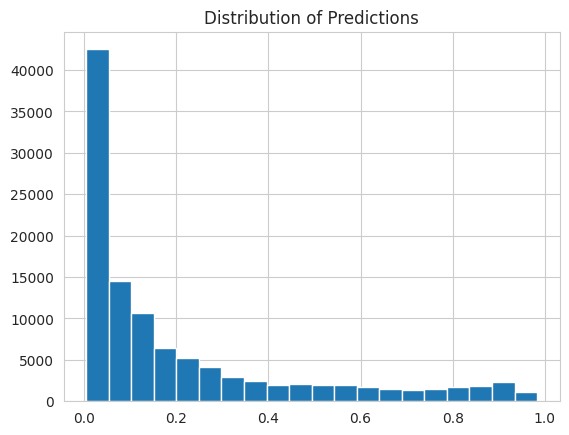

In [101]:
final_preds = preds_ens

plt.hist(final_preds,bins=20)
plt.title('Distribution of Predictions');

In [102]:
ss.Exited = final_preds
ss.to_csv('submission.csv',index=False)
ss.head()

,id,Exited
0,165034,0.019831
1,165035,0.778053
2,165036,0.019000
3,165037,0.308243
4,165038,0.440372


## Print Ratios and Models

In [103]:
output = [config.models[i] + ':' + f'{max_row[i]:.2f}' for i in range(len(models))]
output = ' '.join(output) + f', cv: {max_row.score:.5f}'
output

'dt:0.10 rf:0.01 etc:0.02 xgb:0.27 cat:0.37 lgbm:0.23, cv: 0.88500'

In [36]:
# 100 trials: .88550